## 2026 EY AI & Data Challenge - TerraClimate Demonstration Notebook

This notebooks demonstrates how to access the TerraClimate dataset. TerraClimate is a dataset of monthly climate and climatic water balance for global terrestrial surfaces from 1958 to the present. These data provide important inputs for ecological and hydrological studies at global scales that require high spatial resolution and time-varying data. All data have monthly temporal resolution and a ~4-km (1/24th degree) spatial resolution. This dataset is provided in Zarr format. 

For more information, visit: https://planetarycomputer.microsoft.com/dataset/terraclimate#overview 

## Load In Dependencies
The following code installs the required Python libraries (found in the requirements.txt file) in the Snowflake environment to allow successful execution of the remaining notebook code. After running this code for the first time, it is required to “restart” the kernal so the Python libraries are available in the environment. This is done by selecting the “Connected” menu above the notebook (next to “Run all”) and selecting the “restart kernal” link. Subsequent runs of the notebook do not require this “restart” process.

In [ ]:
!pip install uv
!uv pip install  -r requirements.txt 

In [ ]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import xarray as xr

# Import Planetary Computer tools
import pystac_client
import planetary_computer 
import dask 

# Dask is a dependency of xarray, so it will already be installed.
from dask.distributed import Client

# import Numpy
import numpy as np


In [ ]:
# Snowflake notebooks use Ray by default, which has a fixed object store
# Force Dask scheduler instead of Ray
client = Client(memory_limit='2GB', processes=False)



## Loading TerraClimate Data

In [2]:
# Access STAC catalog and collection.
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace)

collection = catalog.get_collection("terraclimate")
asset = collection.assets["zarr-abfs"]

In [ ]:
# Open dataset and remove CRS.
ds = xr.open_dataset(asset.href,**asset.extra_fields["xarray:open_kwargs"])
ds = ds.drop('crs', dim=None) # Remove the CRS coordinate in the dataset


A list of the available parameters is shown below:
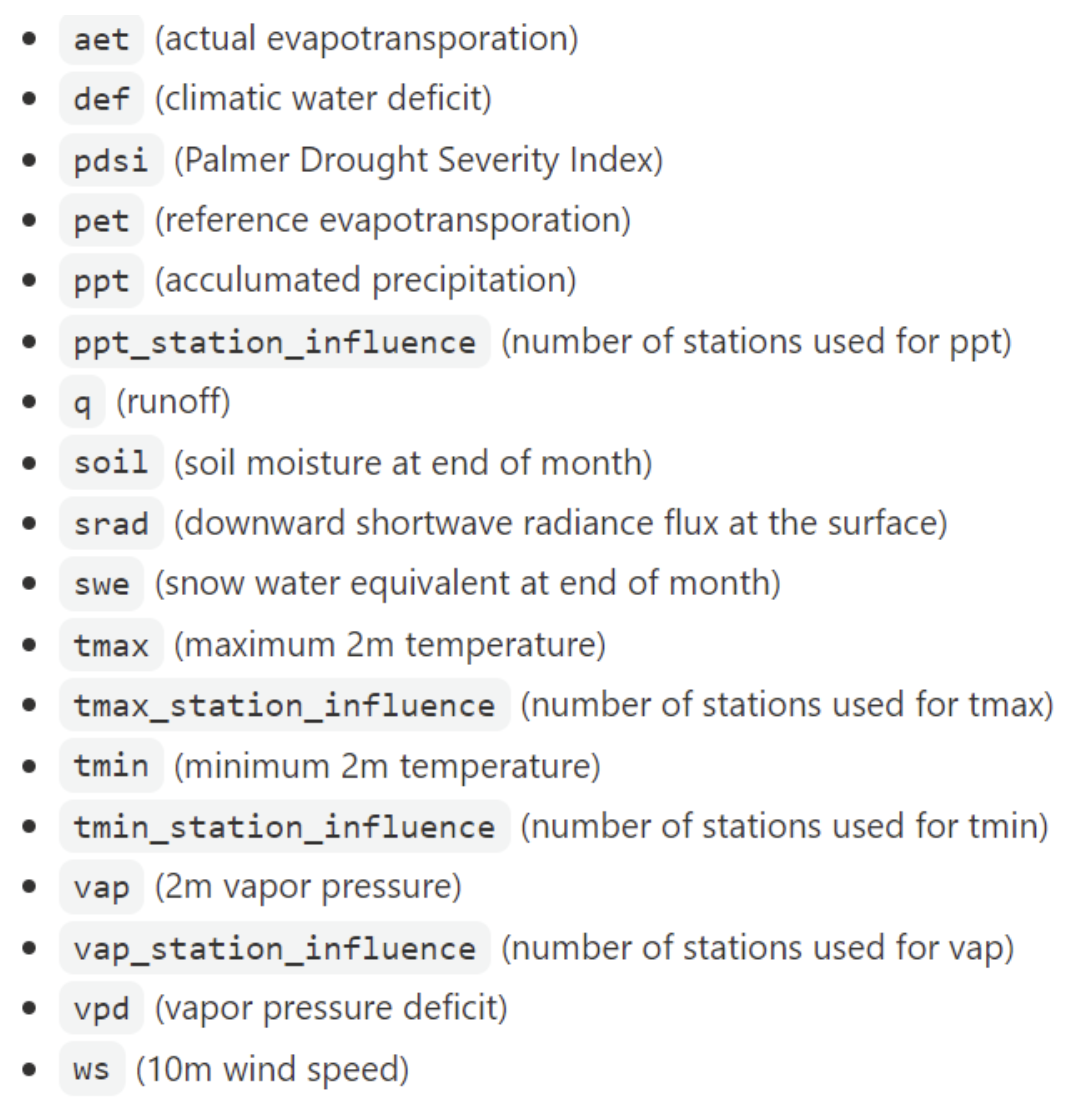

In [4]:
# Since this is a HUGE dataset (nearly 2 TB), we should parse the dataset
# Trimming dataset to years 2011 through 2015
ds = ds.sel(time=slice("2011-01-01", "2015-12-31"))

In [5]:
# Sample region in South Africa
# Contains Water Quality Sample Site #184 and #186 on Wilge River
lat_long = (-27.2923, 28.5365) # Lat-Lon centroid location
box_size_deg = 0.15 # Surrounding box in degrees

In [6]:
# Calculate the Lat-Lon bounding box region
min_lon = lat_long[1]-box_size_deg/2
min_lat = lat_long[0]-box_size_deg/2
max_lon = lat_long[1]+box_size_deg/2
max_lat = lat_long[0]+box_size_deg/2

In [7]:
mask_lon = (ds.lon >= min_lon) & (ds.lon <= max_lon)
mask_lat = (ds.lat >= min_lat) & (ds.lat <= max_lat)

In [8]:
# Crop the dataset to smaller Lat-Lon regions
ds = ds.where(mask_lon & mask_lat, drop=True)
ds

## Exploring the Data

In [9]:
# Plot monthly accumulated precipitation over the region for 5 years
temperature = ds["ppt"].mean(dim=["lat", "lon"])
temperature.plot(figsize=(12, 6));

In [10]:
# Plot monthly reference evapotransporation over the region for 5 years
temperature = ds["pet"].mean(dim=["lat", "lon"])
temperature.plot(figsize=(12, 6));